Import Modules

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,RandomFlip,RandomRotation,RandomTranslation
from keras.optimizers import Adam,schedules
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)
%matplotlib inline

2.9.2


Check GPU

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)

tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Extract & Download Data of Car Images from 5 different brands



In [3]:
 !wget --no-check-certificate \
  https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip \
  -O /tmp/cars.zip

--2022-11-26 07:33:12--  https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Resolving app.box.com (app.box.com)... 74.112.186.144
Connecting to app.box.com (app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip [following]
--2022-11-26 07:33:12--  https://app.box.com/public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Reusing existing connection to app.box.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!hIofGx3zuUyaJ6DOPIuP85cuavouoX42yq_4LZmlnBl5Thswvf9hkAkgStbqUOJmBvYGmFyO0jkbPjUgSoGUmDlhx8DPo5K_cMafV7ob6jp77TQRF1fKb7BDWuzRXynVf2PWe4zhEB-ipXZxiDiPwmuv6qJTzycRW-5GuvRDevopPUt_7Fm6o7SoQRE0vwJpPUPWWNfj4g7UEOBjdTxTCQLBit_CmP96lbzbqymP0FHJUjPGVufohVIJX0PmDfW3YeErqrlEkcf8IXUtisI7nKFY71bUTW5clFygIatxDtNeSlSszyY_Kd-8PF1yTxWWc3UGuOksweWHaSZedX2aAYbVK6oiNfG-0PcWqj7yMjBdWfaJ5On-RvizP72eCyCK8QhAQxmPKjt-z8YfJbiM

Unzip image dataset to folder:tmp and organise folder

In [4]:
import os
import zipfile

local_zip = '/tmp/cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Putting datasets into training, validation and test sets

In [5]:
base_path = '/tmp/cars'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')
#Preprocessing allows for generalization, "stress" the neural network with sth harder, so when it comes to the actual thing, the neural network would work better
#https://deeplizard.com/learn/video/pZoy_j3YsQg (tutorial)

In [6]:
IDG = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_batches = IDG\
.flow_from_directory(directory=train_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

valid_batches = IDG\
.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

test_batches = IDG\
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10,shuffle=False)
 #There are 3 channels which are RGB, thus input shape is (224,224,3)


Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [7]:
imgs, labels = next(train_batches)
print(type(imgs))
test_batches.class_indices # BMW @ index 0 , Bugatti @ index 1, Lam@ index 2, Mclaren@ index 3, Volkswagen@ index 4

<class 'numpy.ndarray'>


{'BMW': 0, 'Bugatti': 1, 'Lamborghini': 2, 'McLaren': 3, 'Volkswagen': 4}

Display 10 example images from the training set.

In [8]:
# This function will plot images in the form of a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

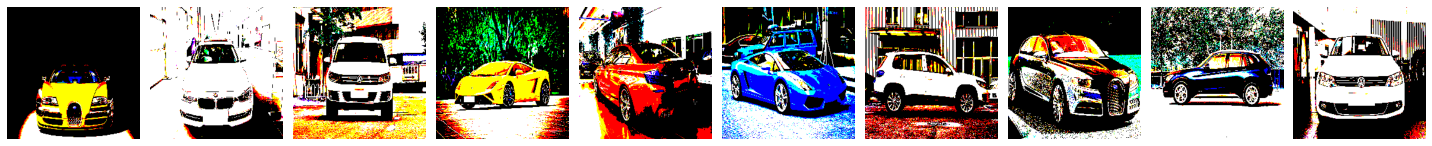

In [9]:
plotImages(imgs)
print(labels)

# **Build a new neural network model from scratch**

In [10]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation ='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(units=5,activation='softmax')])
model.summary()

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history=model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
40/40 - 13s - loss: 35.1785 - accuracy: 0.3300 - val_loss: 9.8464 - val_accuracy: 0.4200 - 13s/epoch - 329ms/step
Epoch 2/10
40/40 - 4s - loss: 2.8355 - accuracy: 0.6575 - val_loss: 6.2174 - val_accuracy: 0.5000 - 4s/epoch - 108ms/step
Epoch 3/10
40/40 - 4s - loss: 0.7288 - accuracy: 0.8425 - val_loss: 5.9798 - val_accuracy: 0.4900 - 4s/epoch - 108ms/step
Epoch 4/10
40/40 - 4s - loss: 0.4236 - accuracy: 0.8950 - val_loss: 4.5195 - val_accuracy: 0.5200 - 4s/epoch - 108ms/step
Epoch 5/10
40/40 - 4s - loss: 0.1113 - accuracy: 0.9725 - val_loss: 4.8420 - val_accuracy: 0.5200 - 4s/epoch - 108ms/step
Epoch 6/10
40/40 - 4s - loss: 0.0219 - accuracy: 0.9925 - val_loss: 4.5684 - val_accuracy: 0.5700 - 4s/epoch - 108ms/step
Epoch 7/10
40/40 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.6979 - val_accuracy: 0.5300 - 4s/epoch - 110ms/step
Epoch 8/10
40/40 - 5s - loss: 2.1625e-04 - accuracy: 1.0000 - val_loss: 4.6771 - val_accuracy: 0.5400 - 5s/epoch - 132ms/step
Epoch 9/10
40/40 

Getting the true label of the test images 

In [13]:
y_test = test_batches.classes
print(type(y_test))
print(y_test)

<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


Using our model to predict the 5 car categories

In [14]:
output_layer = model.predict(x=test_batches, verbose=0)
np.round(output_layer)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0.

In [15]:
y_pred = np.argmax(output_layer, axis=-1)
print(y_pred)


[0 0 0 4 0 0 0 0 4 0 0 3 0 0 2 1 0 3 4 0 1 1 1 3 1 1 1 1 3 1 3 1 1 1 2 1 2
 1 3 1 2 1 2 2 2 3 1 1 3 0 1 2 2 1 2 2 2 1 4 4 3 3 3 3 3 1 2 3 1 3 1 2 3 2
 1 3 3 2 3 3 0 4 4 4 1 0 0 4 2 4 4 1 0 4 3 3 4 4 0 4]


Plot Confusion Matrix

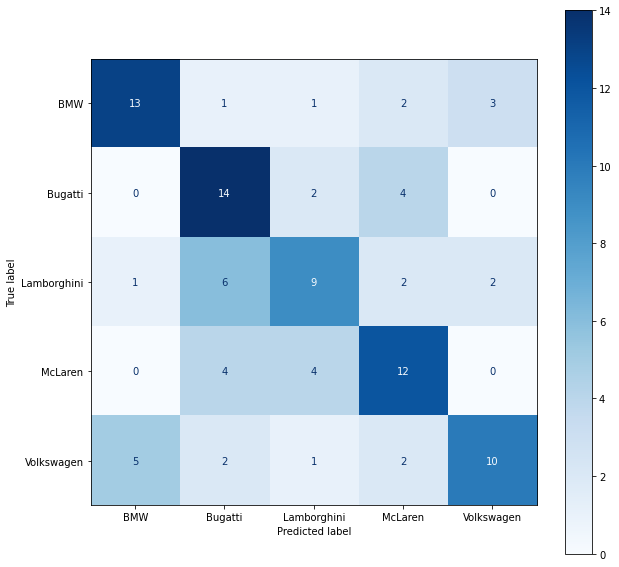

In [16]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)



In [17]:
Accuracy = accuracy_score(y_test, y_pred)
print(Accuracy)

0.58


In [18]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen']))


Classification Report

              precision    recall  f1-score   support

         BMW       0.68      0.65      0.67        20
     Bugatti       0.52      0.70      0.60        20
 Lamborghini       0.53      0.45      0.49        20
     McLaren       0.55      0.60      0.57        20
  Volkswagen       0.67      0.50      0.57        20

    accuracy                           0.58       100
   macro avg       0.59      0.58      0.58       100
weighted avg       0.59      0.58      0.58       100



This model has an accuracy of 58% with an average f1-score of 0.58. The model also do better at identifying BMW and Volkswagen as both of them has a f1 score of 0.68 and 0.77 respectively. It shows that the model has a certain level of biasness.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


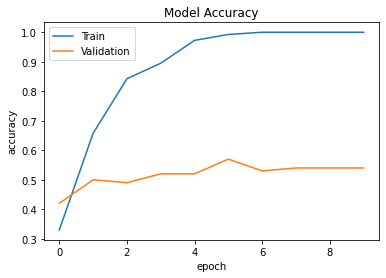

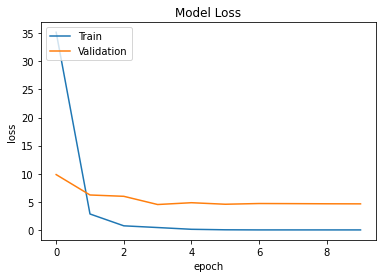

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Suggesion is from:https://machinelearningmastery.com/improve-deep-learning-performance/
#Code is from:https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# ***Changes***

Do data augmentation for regularization pruposes 


In [20]:
IDG=ImageDataGenerator(rescale=1./225,rotation_range=200, horizontal_flip=True,vertical_flip=True, fill_mode='reflect',shear_range=0.2,zoom_range=0.1)
train_batches = IDG.flow_from_directory(directory=train_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

valid_batches = IDG.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'], batch_size=10)

test_batches = IDG.flow_from_directory(directory=test_path, target_size=(224,224), classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'],
                                       batch_size=10,shuffle=False)
 #There are 3 channels which are RGB, thus input shape is (224,224,3)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [21]:
imgs, labels = next(train_batches)
print(imgs)
test_batches.class_indices

[[[[0.55437464 0.55437464 0.55437464]
   [0.6041728  0.6041728  0.6041728 ]
   [0.6241745  0.6241745  0.6241745 ]
   ...
   [0.8889375  0.885531   0.87760276]
   [0.83638805 0.83638805 0.830812  ]
   [0.7933728  0.7933728  0.7933728 ]]

  [[0.5874362  0.5874362  0.5874362 ]
   [0.61725926 0.61725926 0.61725926]
   [0.6322726  0.6322726  0.6322726 ]
   ...
   [0.8957524  0.89130795 0.8773557 ]
   [0.88036907 0.88015604 0.87088776]
   [0.7972316  0.79724324 0.7952416 ]]

  [[0.6150547  0.6150547  0.6150547 ]
   [0.6371607  0.6371607  0.6371607 ]
   [0.65127563 0.65127563 0.65127563]
   ...
   [0.9084937  0.9040492  0.88359624]
   [0.86249834 0.8634812  0.8420374 ]
   [0.8041727  0.8056368  0.79235566]]

  ...

  [[0.4139995  0.4139995  0.4139995 ]
   [0.4118634  0.4118634  0.4118634 ]
   [0.40969002 0.40969002 0.40969002]
   ...
   [0.7307207  0.12369879 0.10259895]
   [0.7714267  0.11110214 0.1326625 ]
   [0.7762379  0.11775654 0.13043936]]

  [[0.4167711  0.4167711  0.4167711 ]
   [0.4

{'BMW': 0, 'Bugatti': 1, 'Lamborghini': 2, 'McLaren': 3, 'Volkswagen': 4}

In [22]:
# This function will plot images in the form of a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

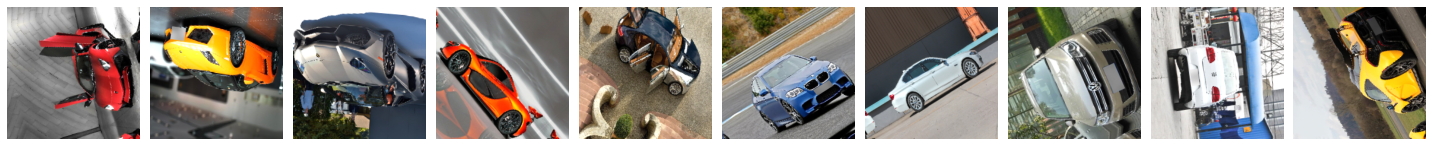

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [23]:
plotImages(imgs)
print(labels)

In [24]:
pip install cutmix-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from cutmix_keras import CutMixImageDataGenerator

In [26]:
train_generator1=IDG\
.flow_from_directory(directory=train_path,target_size=(224,224),classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'],batch_size=10,shuffle=True)
train_generator2=IDG\
.flow_from_directory(directory=train_path,target_size=(224,224),classes=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'],batch_size=10,shuffle=True)
train_generator = CutMixImageDataGenerator(
    generator1=train_generator1,
    generator2=train_generator2,
    img_size=(224), #only accept one argument, it will set the width and height to be the same
    batch_size=10)
B=train_generator.samples

Found 400 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [27]:
img, label = next(train_generator)
print(type(img))

<class 'numpy.ndarray'>


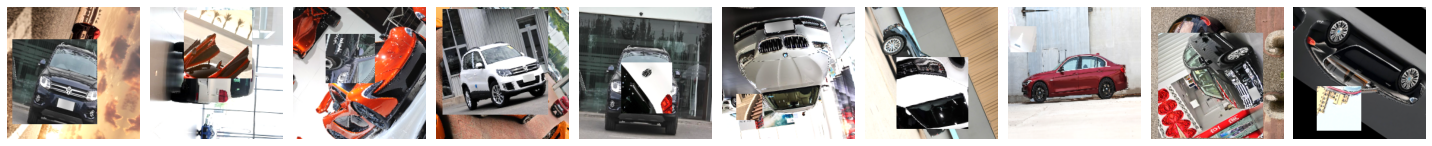

[[0.         0.         0.         0.58519442 0.41480558]
 [0.         0.         0.         0.26607888 0.73392112]
 [0.         0.         0.         0.85968884 0.14031116]
 [0.         0.         0.36       0.         0.64      ]
 [0.         0.         0.         0.         1.        ]
 [0.96       0.04       0.         0.         0.        ]
 [0.70129462 0.         0.         0.         0.29870538]
 [0.96       0.         0.         0.         0.04      ]
 [0.         0.36904089 0.         0.         0.63095911]
 [0.1140354  0.8859646  0.         0.         0.        ]]


In [28]:
plotImages(img)
print(label)

In [29]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical",input_shape=(224,224,3)),
  RandomRotation(factor=0.5),
  RandomTranslation(height_factor=(0.1),
    width_factor=(0.1),
    fill_mode='wrap',
    interpolation='bilinear',
    seed=None,)])
data_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


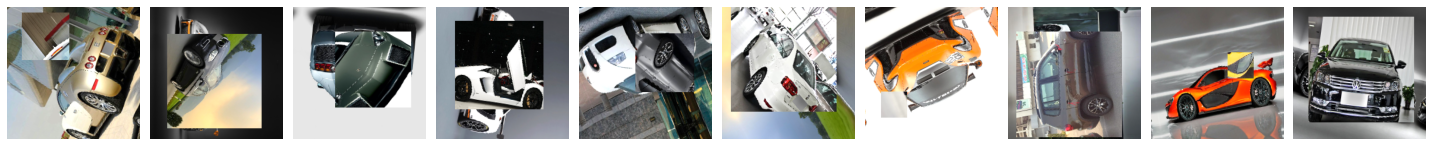

[[0.13015316 0.86984684 0.         0.         0.        ]
 [0.50891208 0.         0.         0.49108792 0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.45075863 0.54924137 0.        ]
 [0.19786331 0.80213669 0.         0.         0.        ]
 [0.36       0.         0.         0.         0.64      ]
 [0.         0.         0.04       0.96       0.        ]
 [0.         0.         0.36       0.         0.64      ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.36       0.         0.         0.64      ]]


In [30]:
img, label = next(train_generator)
augmented_images = data_augmentation(img)
plotImages(img)
print(label)

In [31]:
model1 = Sequential(
    [data_augmentation,    
    Conv2D(filters=32,kernel_size=(3,3),activation ='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(units=5,activation='softmax')]  
)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)      

In [32]:
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
A=train_generator.get_steps_per_epoch()
print(A)

40


In [33]:
history1=model1.fit(x=train_generator, validation_data=valid_batches, epochs=150, verbose=1,steps_per_epoch=A)

Epoch 1/150


40/40 [==============================] - 29s 680ms/step - loss: 1.6351 - accuracy: 0.1725 - val_loss: 1.6108 - val_accuracy: 0.2100
Epoch 2/150
40/40 [==============================] - 17s 424ms/step - loss: 1.5821 - accuracy: 0.2750 - val_loss: 1.5416 - val_accuracy: 0.2600
Epoch 3/150
40/40 [==============================] - 16s 418ms/step - loss: 1.5553 - accuracy: 0.2775 - val_loss: 1.5182 - val_accuracy: 0.3200
Epoch 4/150
40/40 [==============================] - 16s 416ms/step - loss: 1.5103 - accuracy: 0.3575 - val_loss: 1.3864 - val_accuracy: 0.4000
Epoch 5/150
40/40 [==============================] - 18s 453ms/step - loss: 1.4735 - accuracy: 0.3925 - val_loss: 1.3433 - val_accuracy: 0.4300
Epoch 6/150
40/40 [==============================] - 16s 415ms/step - loss: 1.4522 - accuracy: 0.3775 - val_loss: 1.3753 - val_accuracy: 0.3800
Epoch 7/150
40/40 [==============================] - 16s 417ms/step - loss: 1.4532 - accuracy: 0.3975 - val_loss: 1.3808 - val_accuracy: 0.3700
Epoc

In [34]:
y_test = test_batches.classes
print(type(y_test))
print(y_test)

<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [35]:
output_layer1 = model1.predict(x=test_batches, verbose=0)
np.round(output_layer1)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

In [36]:
y_pred1 = np.argmax(output_layer1, axis=-1)
print(y_pred1)

[0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1
 3 1 1 2 2 4 3 2 3 0 1 2 0 2 0 2 0 2 2 2 2 4 2 3 1 3 3 3 3 3 3 0 3 4 3 3 3
 3 3 3 2 3 3 0 2 4 0 4 4 0 0 4 4 4 0 4 4 4 0 4 4 4 4]


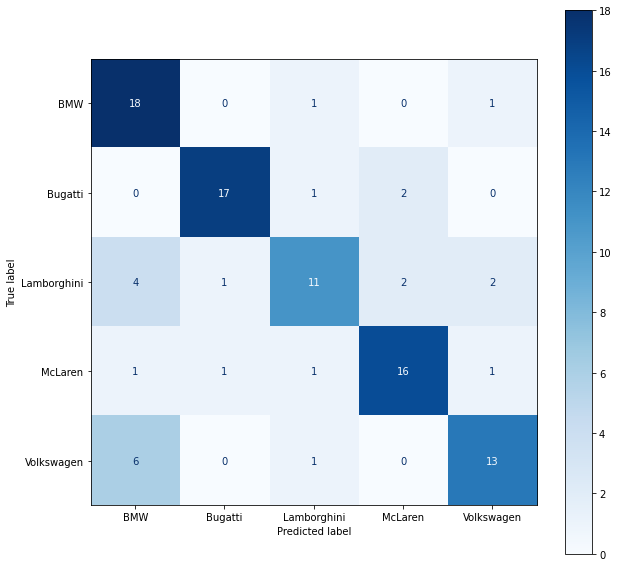

In [37]:
cm1 = confusion_matrix(y_test, y_pred1)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen'])
fig, ax = plt.subplots(figsize=(10,10))
disp1.plot(ax=ax,cmap=plt.cm.Blues)

In [38]:
Accuracy = accuracy_score(y_test, y_pred1)
print(Accuracy)

0.75


In [39]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred1, target_names=['BMW', 'Bugatti', 'Lamborghini','McLaren','Volkswagen']))


Classification Report

              precision    recall  f1-score   support

         BMW       0.62      0.90      0.73        20
     Bugatti       0.89      0.85      0.87        20
 Lamborghini       0.73      0.55      0.63        20
     McLaren       0.80      0.80      0.80        20
  Volkswagen       0.76      0.65      0.70        20

    accuracy                           0.75       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


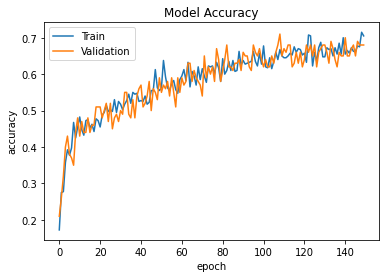

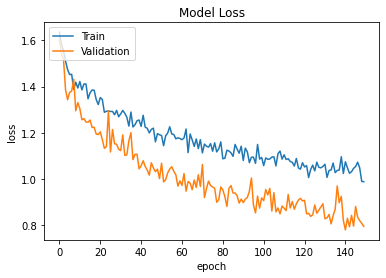

In [40]:
#Suggesion is from:https://machinelearningmastery.com/improve-deep-learning-performance/
#Code is from:https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')#The history for the validation dataset is labeled test by convention as it is indeed a test dataset for the model.
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()